# Spam SMS Detection 

### Objective :-
Build an AI model that can classify SMS messages as spam or legitimate. Use techniques like TF-IDF or word embeddings with classifiers like Naive Bayes, Logistic Regression, or Support Vector Machines to identify spam messages.

### Data Description :-

##### The dataset used in this project is the "spam.csv".

- The SMS Spam Collection is a set of SMS tagged messages that have been collected for SMS Spam research. It contains one set of SMS messages in English of 5,574 messages, tagged acording being ham (legitimate) or spam.
- The files contain one message per line. Each line is composed by two columns : v1 contains the label (ham or spam) and v2 contains the raw text.

## Importing Necessary Libraries :

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
import string
from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import warnings
warnings.filterwarnings('ignore')

## Loading the Dataset :

In [2]:
df = pd.read_csv("/Users/kavu_rojasara/Desktop/Internship/spam.csv", encoding = 'latin-1')
df

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


In [3]:
df.shape

(5572, 5)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


## Data Preprocessing :

In [5]:
# Drop unnecessary columns

df.drop(columns = ['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], inplace = True)

In [6]:
# Rename the column 'v1' as 'Target' and 'v2' as 'Text'

df.rename(columns = {'v1': 'Target', 'v2': 'Text'}, inplace = True)

In [7]:
# Encode the categorical columns into numerical columns

encoder = LabelEncoder()
df['Target'] = encoder.fit_transform(df['Target'])
print('Column : Target')
print('Original categories :', encoder.classes_)
print('Encoded values :', encoder.transform(encoder.classes_))

Column : Target
Original categories : ['ham' 'spam']
Encoded values : [0 1]


In [8]:
# Check the null values 

df.isnull().sum()

Target    0
Text      0
dtype: int64

In [9]:
# Check the duplicate values 

df.duplicated().sum()

403

In [10]:
# Drop the duplicate values 

df = df.drop_duplicates(keep = 'first')
df.duplicated().sum()

0

In [11]:
# Shape after dropping the duplicate values

df.shape

(5169, 2)

In [12]:
df.head()

,Target,Text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


## Exploratory Data Analysis :

In [13]:
df['Target'].value_counts()

Target
0    4516
1     653
Name: count, dtype: int64

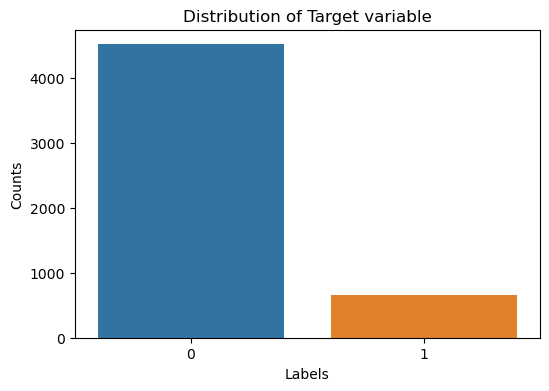

In [14]:
# Distribution of target variable

plt.figure(figsize = (6, 4))
sns.countplot(x = 'Target', data = df)
plt.title('Distribution of Target variable')
plt.xlabel('Labels')
plt.ylabel('Counts')
plt.show()

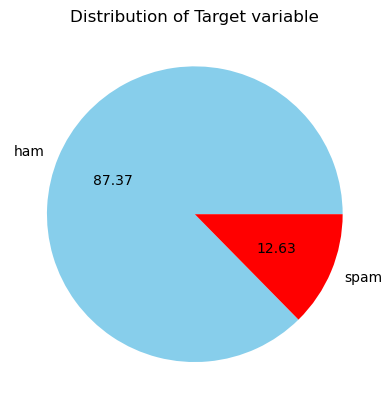

In [15]:
plt.pie(df['Target'].value_counts(), labels = ['ham', 'spam'], autopct = '%0.2f', colors = ['skyblue','red'])
plt.title('Distribution of Target variable')
plt.show()

In [16]:
# Basic statistics of the message lengths

df['message_length'] = df['Text'].apply(len)
print(df['message_length'].describe())

count    5169.000000
mean       78.977945
std        58.236293
min         2.000000
25%        36.000000
50%        60.000000
75%       117.000000
max       910.000000
Name: message_length, dtype: float64


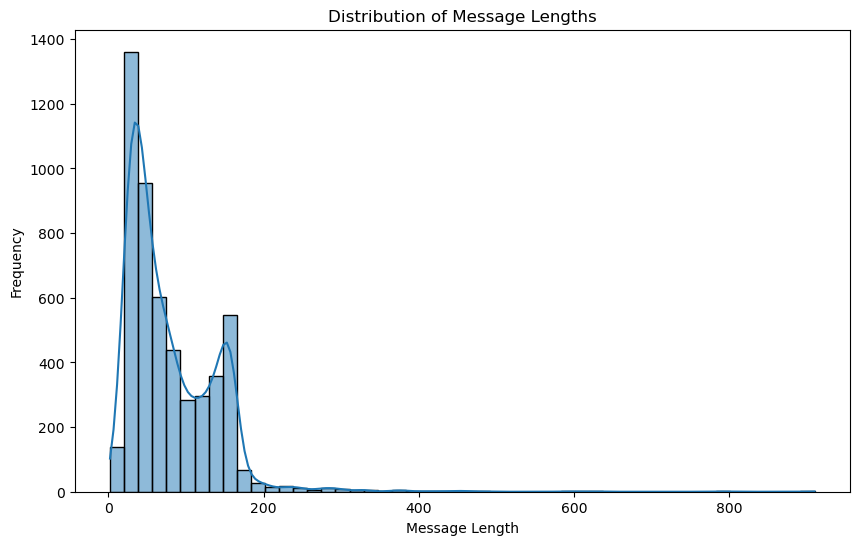

In [17]:
# Plot the distribution of message lengths

plt.figure(figsize = (10, 6))
sns.histplot(df['message_length'], bins = 50, kde = True)
plt.title('Distribution of Message Lengths')
plt.xlabel('Message Length')
plt.ylabel('Frequency')
plt.show()

## Feature Enginering :

In [18]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kavu_rojasara/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/kavu_rojasara/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [19]:
# Basic text features

df['num_words'] = df['Text'].apply(lambda x: len(x.split()))
df['num_unique_words'] = df['Text'].apply(lambda x: len(set(x.split())))
df['num_chars'] = df['Text'].apply(len)
df['num_stopwords'] = df['Text'].apply(lambda x: len([word for word in x.split() if word in stopwords.words('english')]))
df['num_punctuations'] = df['Text'].apply(lambda x: len([char for char in x if char in string.punctuation]))
df['num_hastags'] = df['Text'].apply(lambda x: len([word for word in x.split() if word.startswith('#')]))
df['num_mentions'] = df['Text'].apply(lambda x: len([word for word in x.split() if word.startswith('@')]))

In [20]:
df.head()

,Target,Text,message_length,num_words,num_unique_words,num_chars,num_stopwords,num_punctuations,num_hastags,num_mentions
0,0,"Go until jurong point, crazy.. Available only ...",111,20,20,111,4,9,0,0
1,0,Ok lar... Joking wif u oni...,29,6,6,29,0,6,0,0
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,28,24,155,5,6,0,0
3,0,U dun say so early hor... U c already then say...,49,11,10,49,2,6,0,0
4,0,"Nah I don't think he goes to usf, he lives aro...",61,13,12,61,5,2,0,0


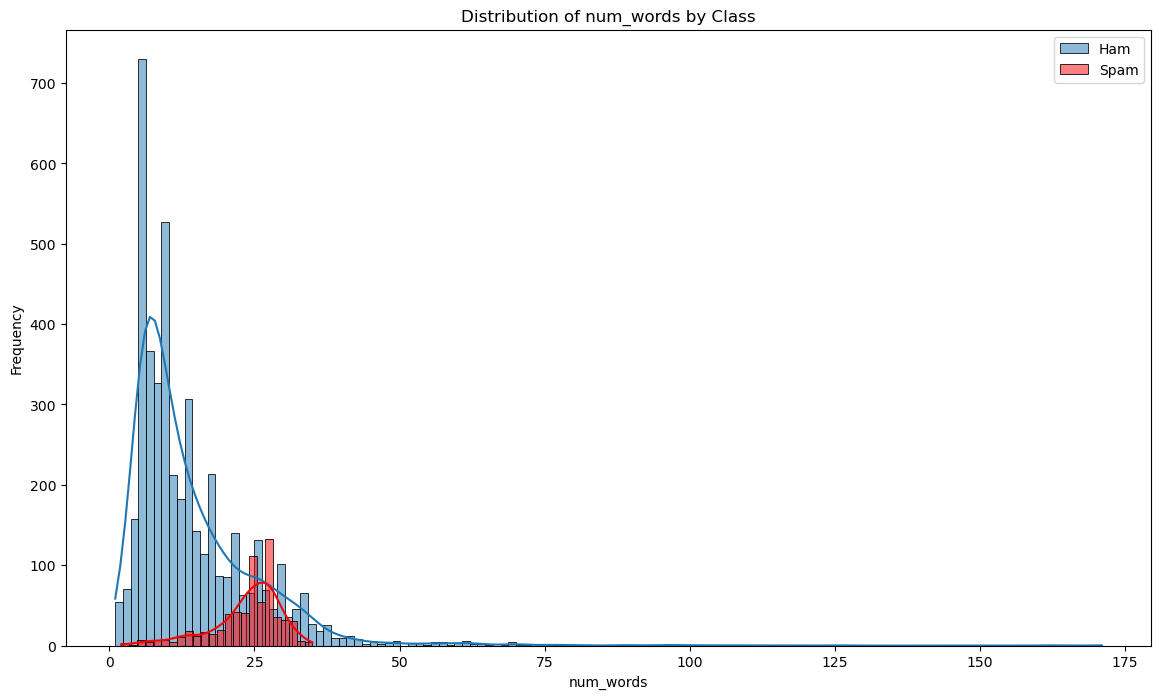

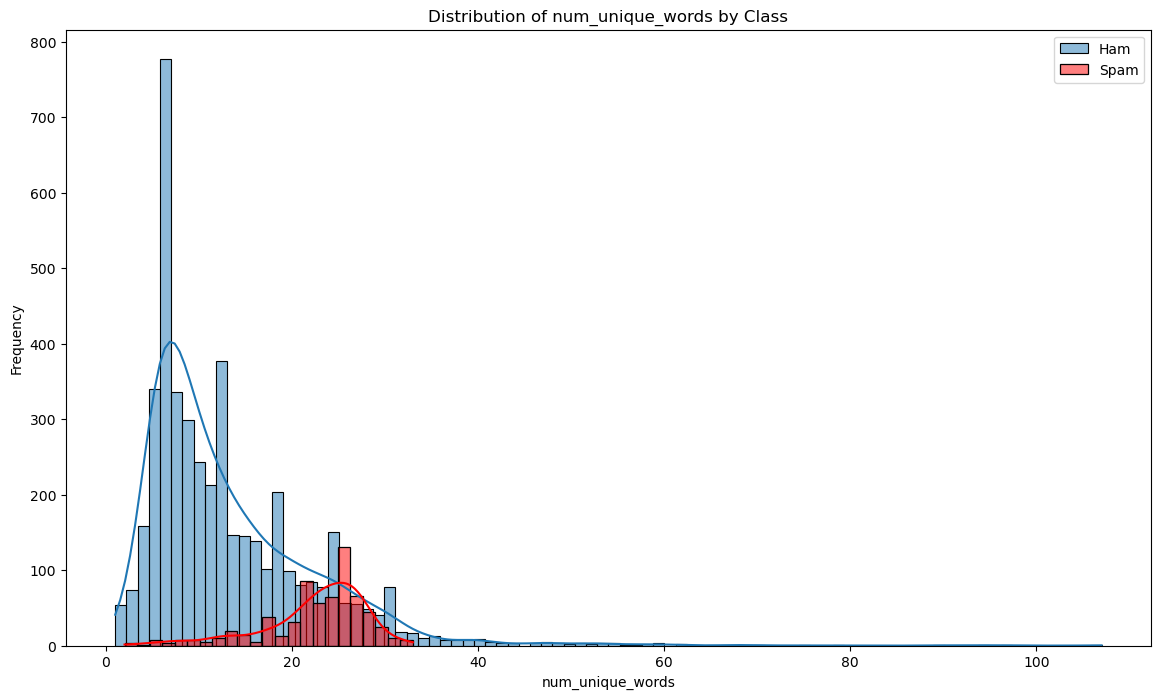

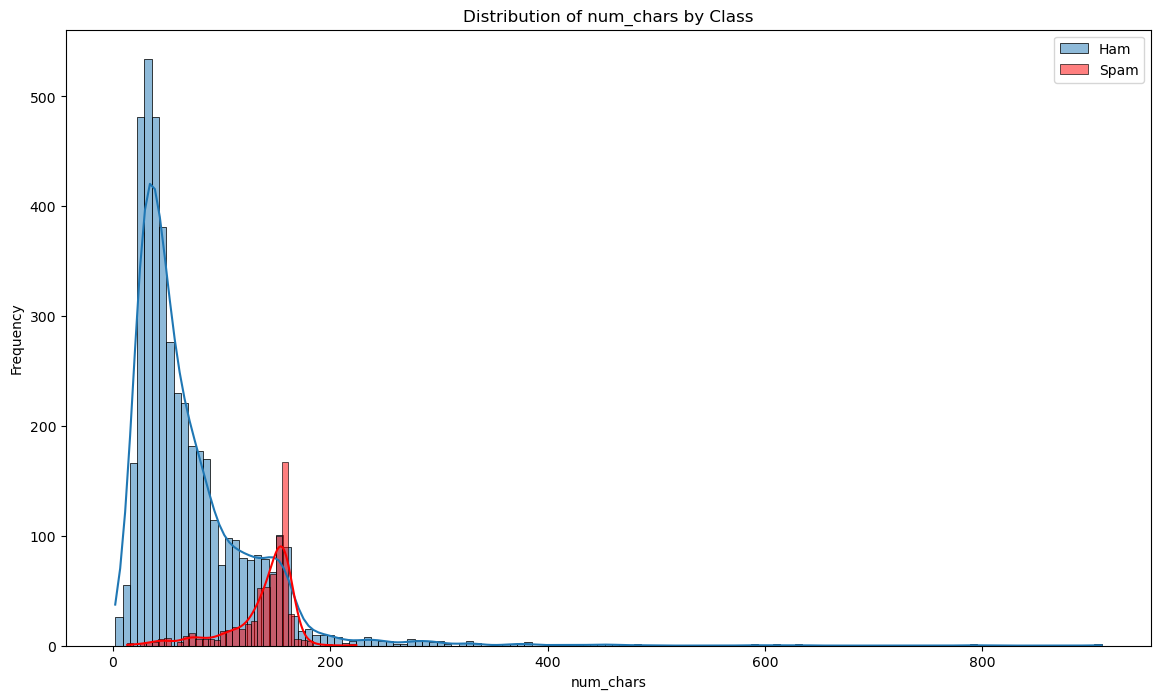

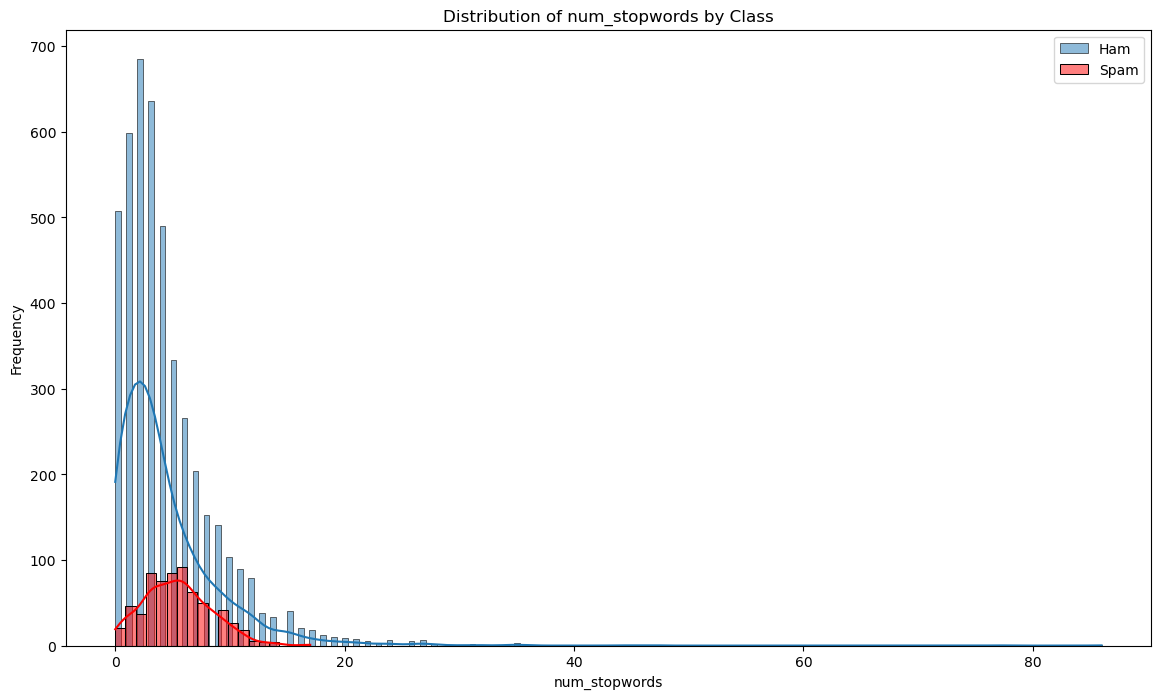

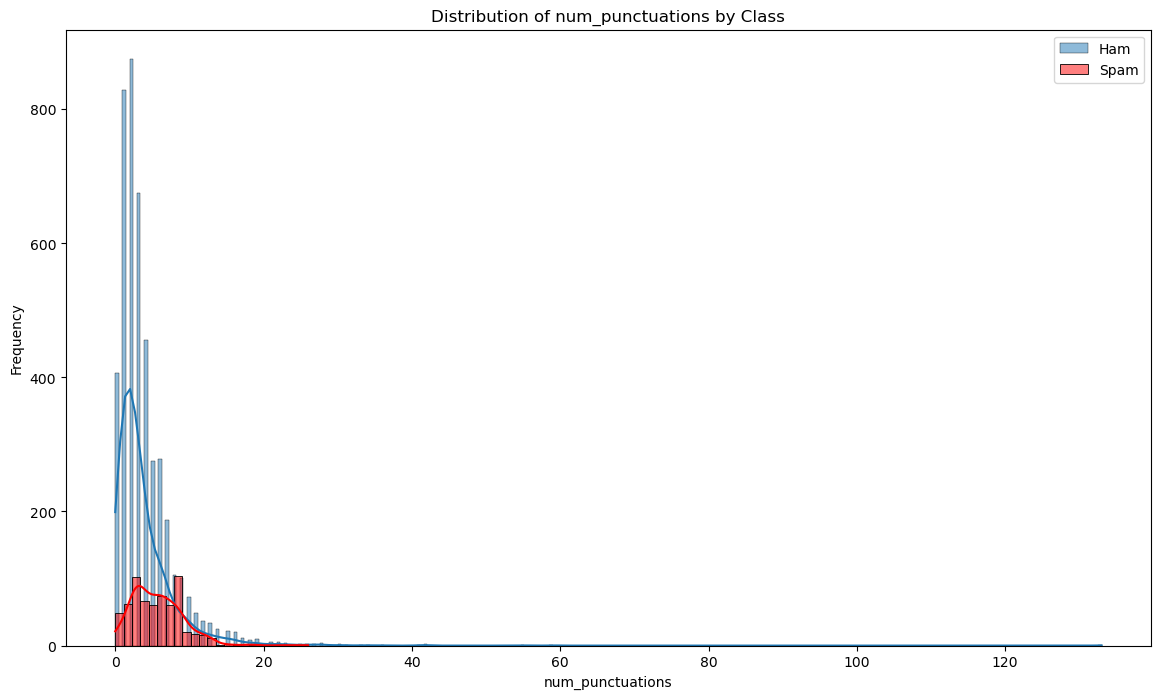

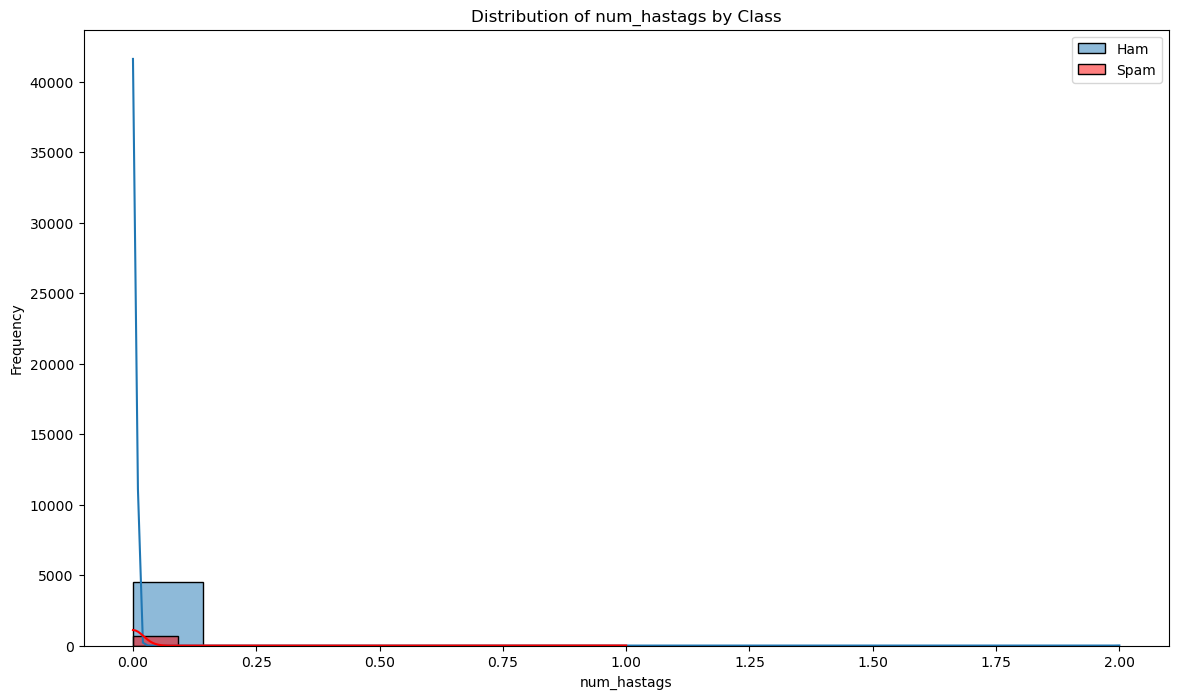

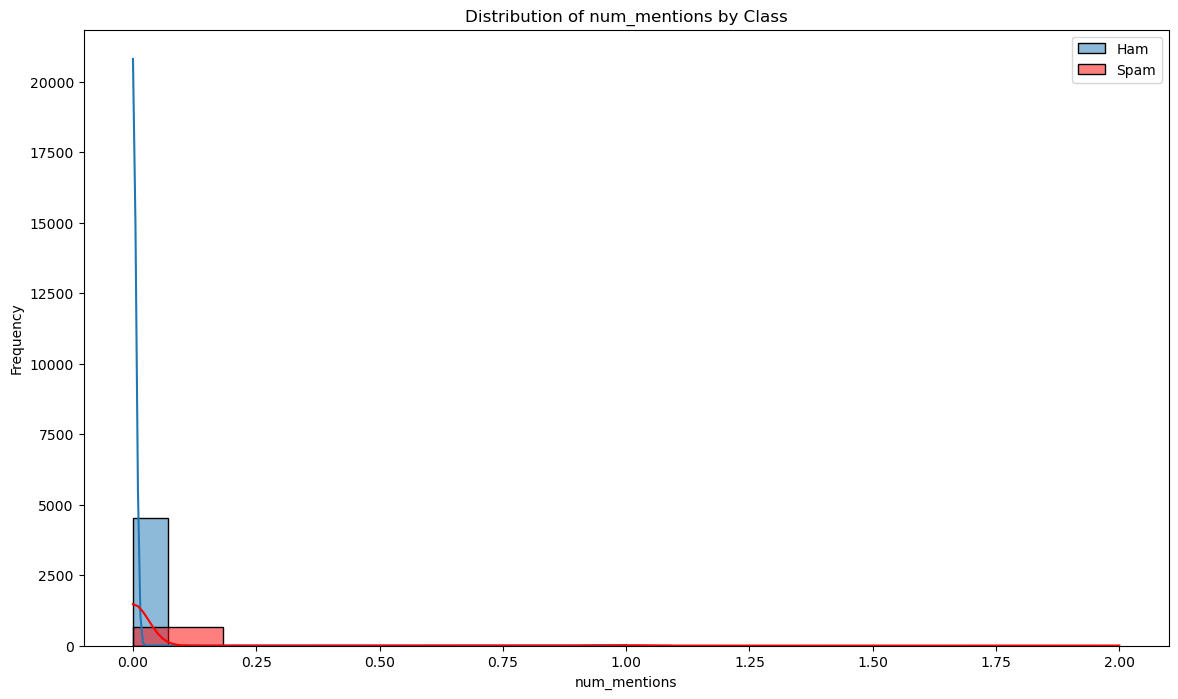

In [21]:
features = ['num_words', 'num_unique_words', 'num_chars', 'num_stopwords', 'num_punctuations', 'num_hastags', 'num_mentions']

# Create histograms for each feature

for feature in features:
    plt.figure(figsize = (14, 8))
    sns.histplot(df[df['Target'] == 0][feature], label = 'Ham', kde = True)
    sns.histplot(df[df['Target'] == 1][feature], color = 'red', label = 'Spam', kde = True)
    plt.title(f'Distribution of {feature} by Class')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

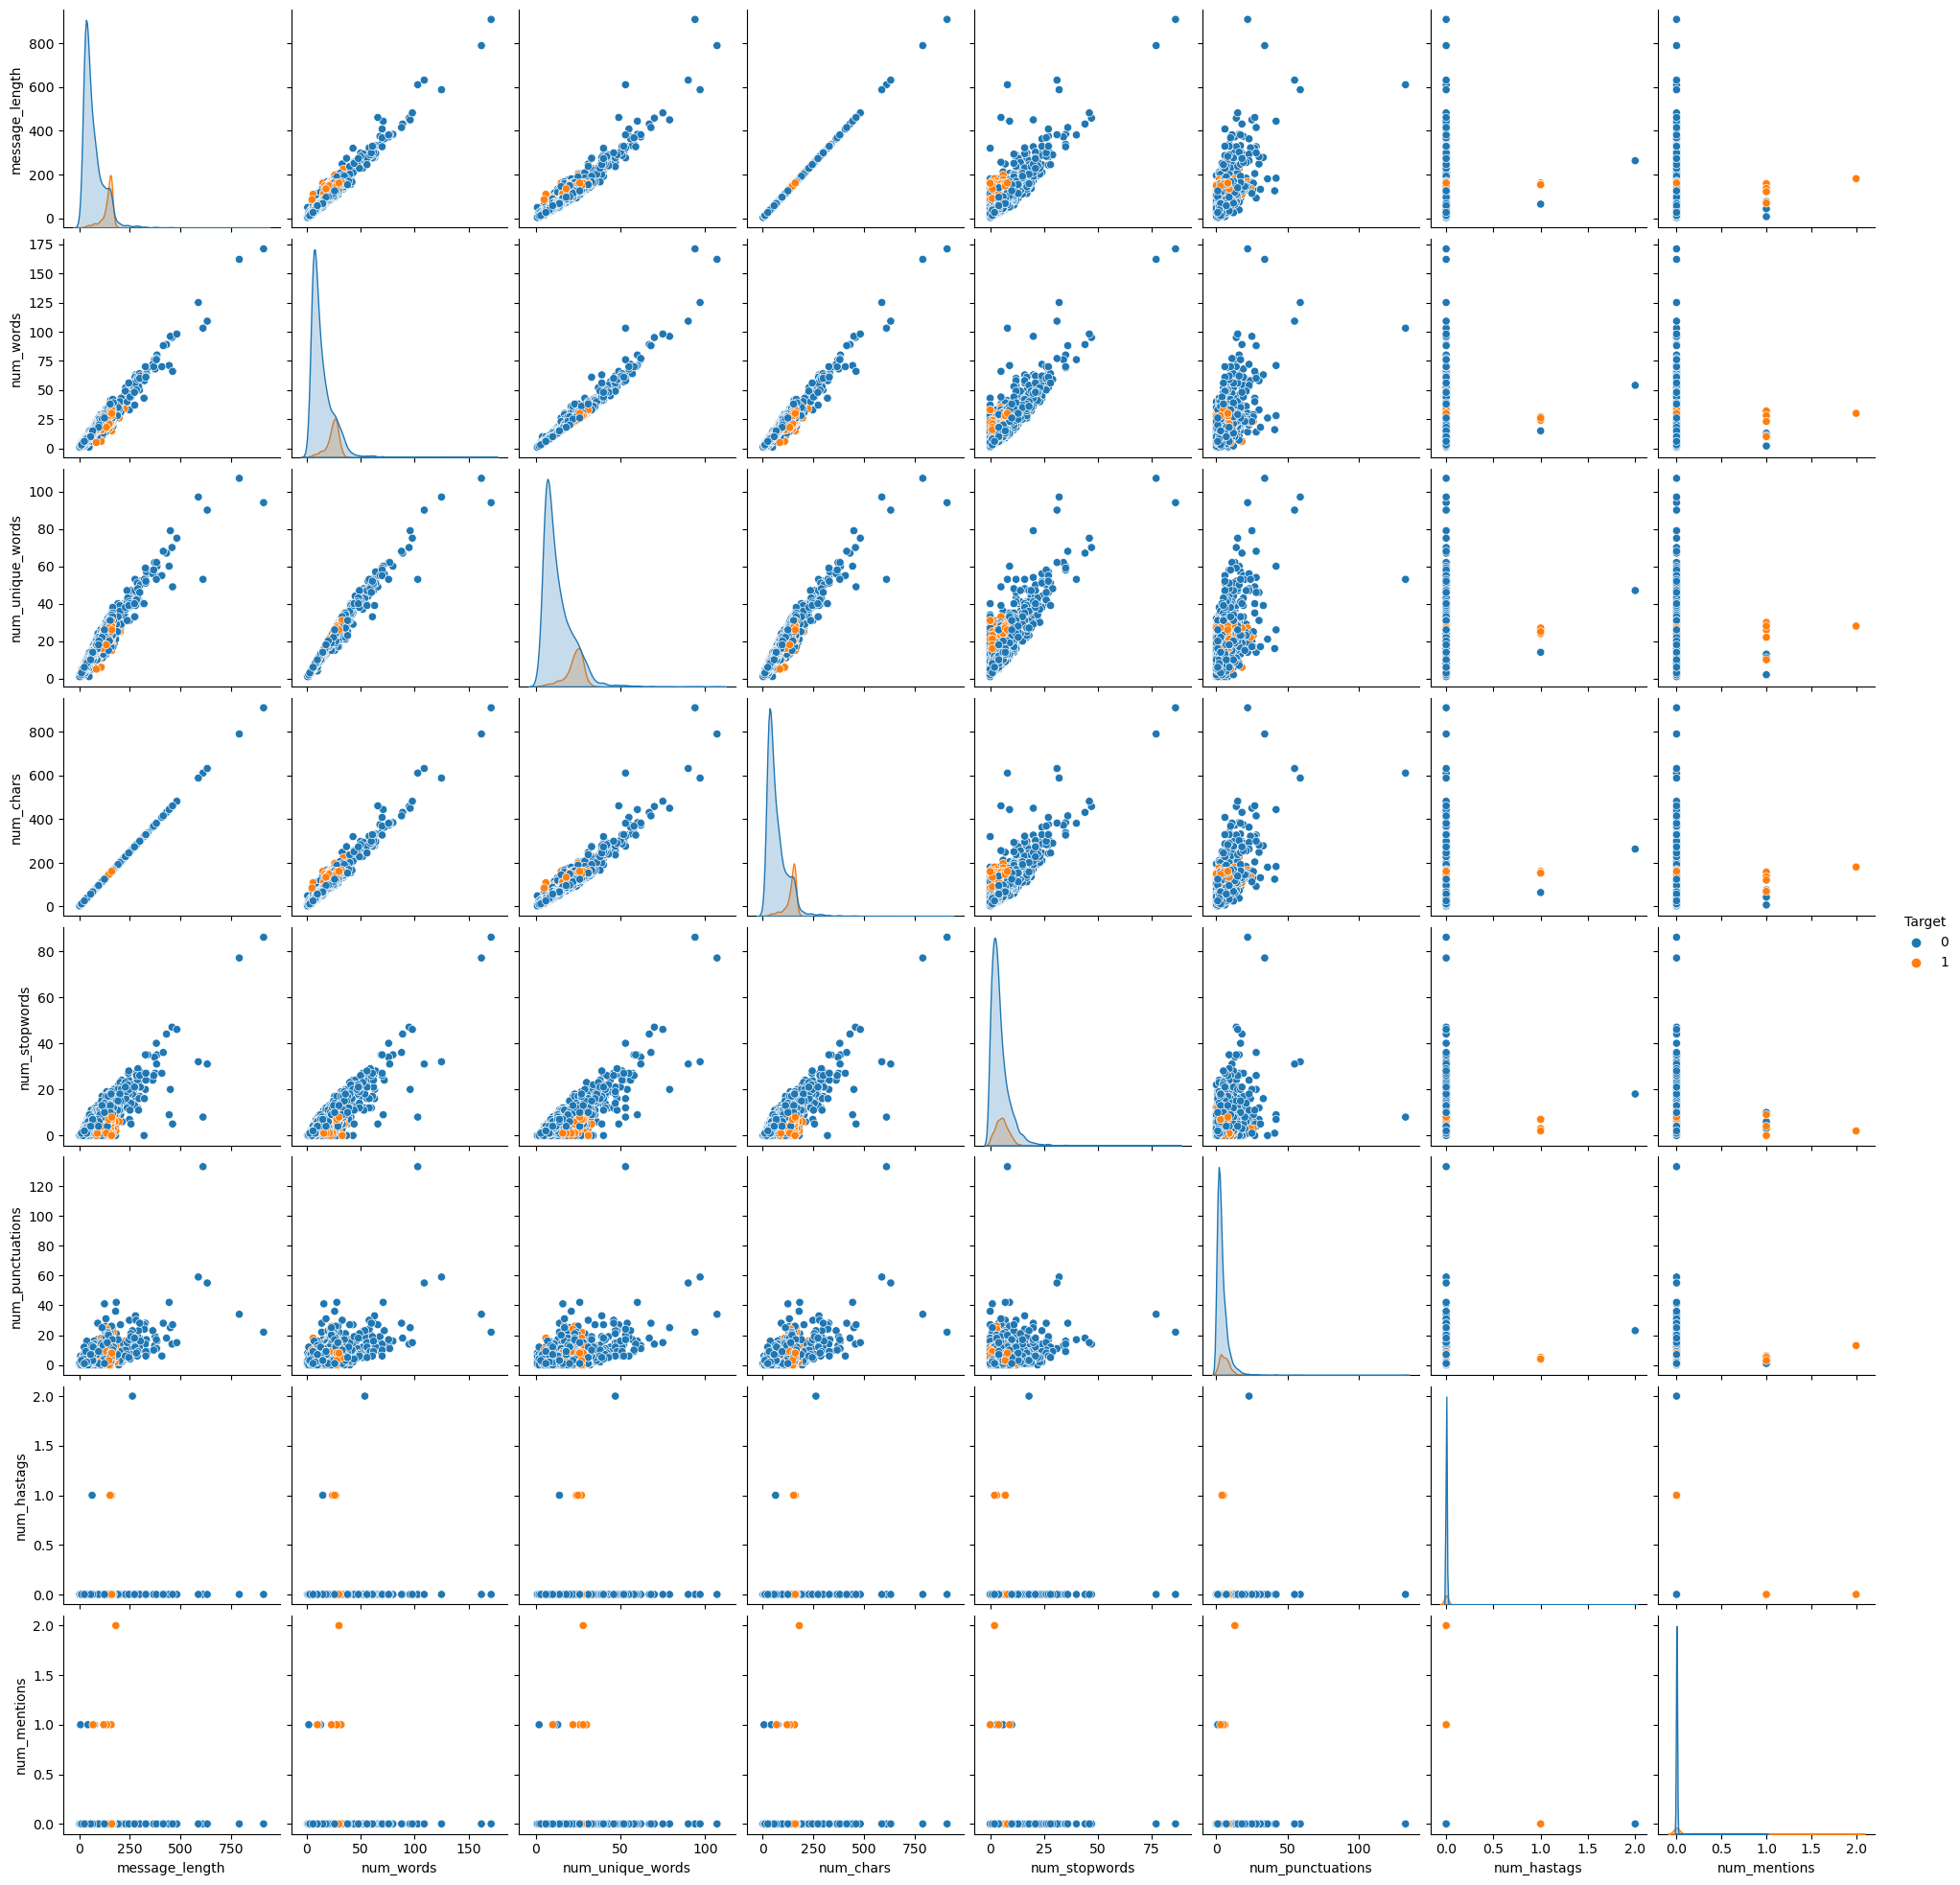

In [22]:
sns.pairplot(df, hue = 'Target')

<Axes: >

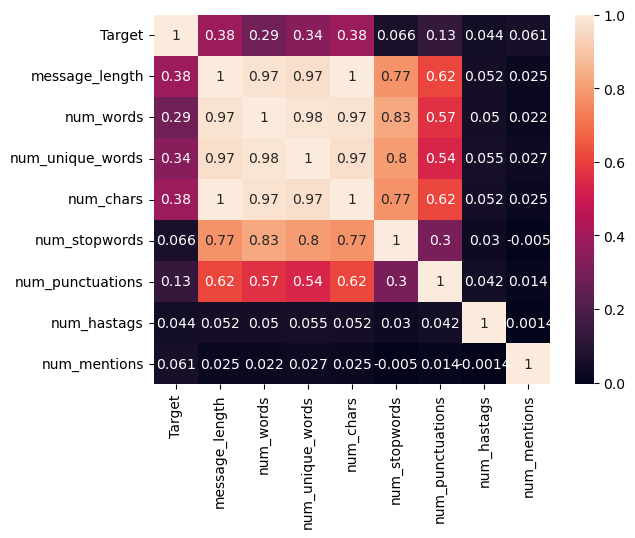

In [23]:
sns.heatmap(df.corr(numeric_only = True), annot = True)

In [24]:
# Function to clean text data

def clean_text(text):
    text = text.lower()  # Lowercase text
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'\W+', ' ', text)  # Remove non-alphanumeric characters
    text = text.split()  # Split text into words
    text = [word for word in text if word not in stopwords.words('english')]  # Remove stopwords
    lemmatizer = WordNetLemmatizer()
    text = [lemmatizer.lemmatize(word) for word in text]  # Lemmatize words
    text = ' '.join(text)  # Join words back into a single string
    return text

In [25]:
df['Text'][432]

'Congrats! Nokia 3650 video camera phone is your Call 09066382422 Calls cost 150ppm Ave call 3mins vary from mobiles 16+ Close 300603 post BCM4284 Ldn WC1N3XX'

In [26]:
clean_text('Congrats! Nokia 3650 video camera phone is your Call 09066382422 Calls cost 150ppm Ave call 3mins vary from mobiles 16+ Close 300603 post BCM4284 Ldn WC1N3XX')

'congrats nokia video camera phone call call cost ppm ave call min vary mobile close post bcm ldn wcnxx'

In [27]:
df['cleaned_text'] = df['Text'].apply(clean_text)

In [28]:
df.head()

,Target,Text,message_length,num_words,num_unique_words,num_chars,num_stopwords,num_punctuations,num_hastags,num_mentions,cleaned_text
0,0,"Go until jurong point, crazy.. Available only ...",111,20,20,111,4,9,0,0,go jurong point crazy available bugis n great ...
1,0,Ok lar... Joking wif u oni...,29,6,6,29,0,6,0,0,ok lar joking wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,28,24,155,5,6,0,0,free entry wkly comp win fa cup final tkts st ...
3,0,U dun say so early hor... U c already then say...,49,11,10,49,2,6,0,0,u dun say early hor u c already say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,13,12,61,5,2,0,0,nah think go usf life around though


## Word Cloud Analysis :

In [29]:
wc = WordCloud(width = 800, height = 400, min_font_size = 5, background_color = 'black')

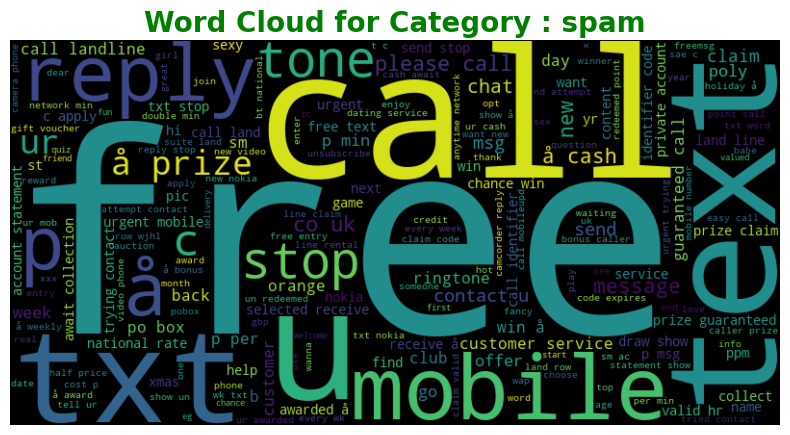

In [30]:
# For Spam

spam_wc = wc.generate(df[df['Target'] == 1]['cleaned_text'].str.cat(sep = " "))

plt.figure(figsize = (10, 5))
plt.imshow(wc, interpolation = 'bilinear', cmap = 'viridis')
plt.title(f'Word Cloud for Category : spam', fontsize = 20, fontweight = 'bold', color = 'green')
plt.axis('off')
plt.show()

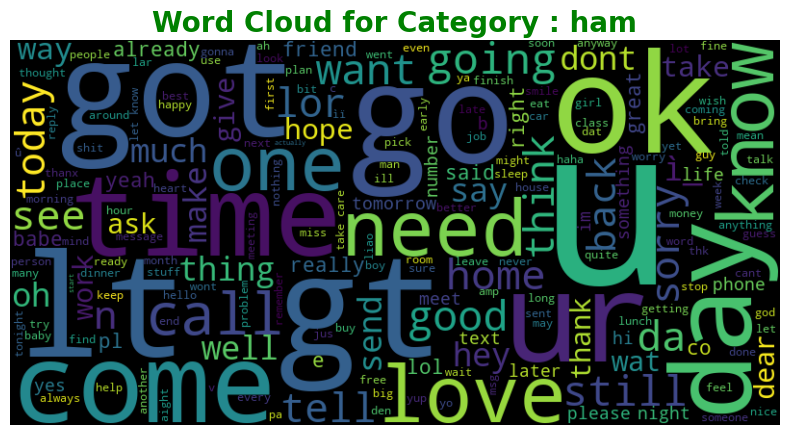

In [31]:
# For Ham

spam_wc = wc.generate(df[df['Target'] == 0]['cleaned_text'].str.cat(sep = " "))

plt.figure(figsize = (10, 5))
plt.imshow(wc, interpolation = 'bilinear', cmap = 'viridis')
plt.title(f'Word Cloud for Category : ham', fontsize = 20, fontweight = 'bold', color = 'green')
plt.axis('off')
plt.show()

## Top Words Frequency Analysis :

In [32]:
# For Spam

spam_corpus = []
for msg in df[df['Target'] == 1]['cleaned_text'].tolist():
    for word in msg.split():
        spam_corpus.append(word)

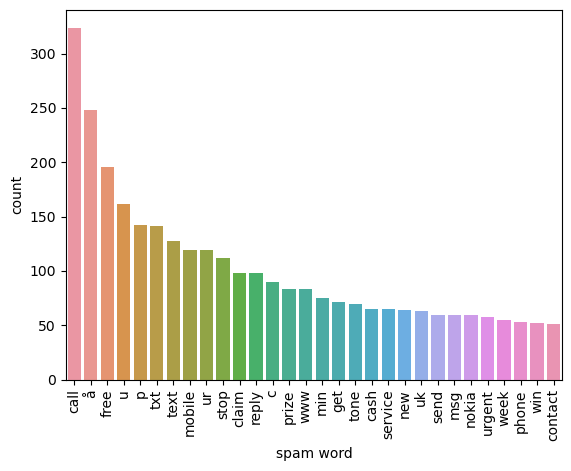

In [33]:
most_common_words = pd.DataFrame(Counter(spam_corpus).most_common(30), columns = ['spam word', 'count'])
sns.barplot(x = 'spam word', y = 'count', data = most_common_words)
plt.xticks(rotation = 'vertical')
plt.show()

In [34]:
# For Ham

ham_corpus = []
for msg in df[df['Target'] == 0]['cleaned_text'].tolist():
    for word in msg.split():
        ham_corpus.append(word)

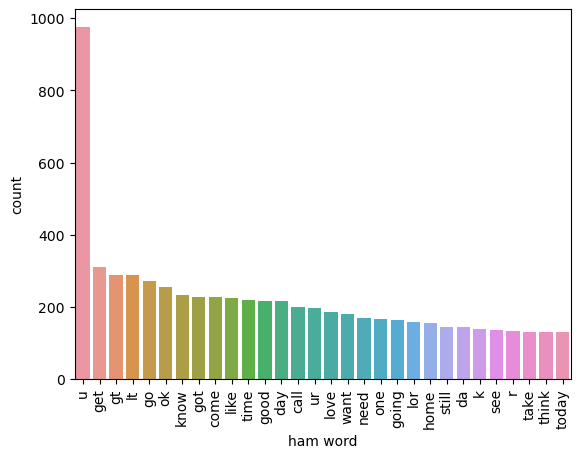

In [35]:
most_common_words = pd.DataFrame(Counter(ham_corpus).most_common(30), columns = ['ham word', 'count'])
sns.barplot(x = 'ham word', y = 'count', data = most_common_words)
plt.xticks(rotation = 'vertical')
plt.show()

## Text Vectorization and Model Building :

In [36]:
cv = CountVectorizer()
tfidf = TfidfVectorizer(max_features = 3000)

In [37]:
X = tfidf.fit_transform(df['cleaned_text']).toarray()
y = df['Target'].values

In [38]:
# Splitting the dataset

X_train,X_test,y_train,y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

## Model Initialization and Evaluation :

In [39]:
# Initialize the models

models = {
    'Logistic Regression': LogisticRegression(),
    'SVC': SVC(),
    'Naive Bayes': GaussianNB(),
    'Multinomial Naive Bayes': MultinomialNB(),
    'Bernoulli Naive Bayes' : BernoulliNB()
}

In [40]:
# Function to evaluate models

def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    return accuracy, precision, recall, f1

In [41]:
# Evaluate each model

results = {}
for name, model in models.items():
    accuracy, precision, recall, f1 = evaluate_model(model, X_train, y_train, X_test, y_test)
    results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }
    
# Create a DataFrame to display the results
results_df = pd.DataFrame(results).T
results_df

,Accuracy,Precision,Recall,F1 Score
Logistic Regression,0.953578,0.944954,0.710345,0.811024
SVC,0.979691,0.984375,0.868966,0.923077
Naive Bayes,0.872340,0.528139,0.841379,0.648936
Multinomial Naive Bayes,0.974855,0.983740,0.834483,0.902985
Bernoulli Naive Bayes,0.980658,0.962963,0.896552,0.928571


In [42]:
bnb_model = BernoulliNB()
bnb_model.fit(X_train, y_train)

y_pred = bnb_model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)

print('Confusion Matrix :')
print(conf_matrix)
print('\nClassification Report :')
print(classification_report(y_test, y_pred))

Confusion Matrix :
[[884   5]
 [ 15 130]]

Classification Report :
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       889
           1       0.96      0.90      0.93       145

    accuracy                           0.98      1034
   macro avg       0.97      0.95      0.96      1034
weighted avg       0.98      0.98      0.98      1034



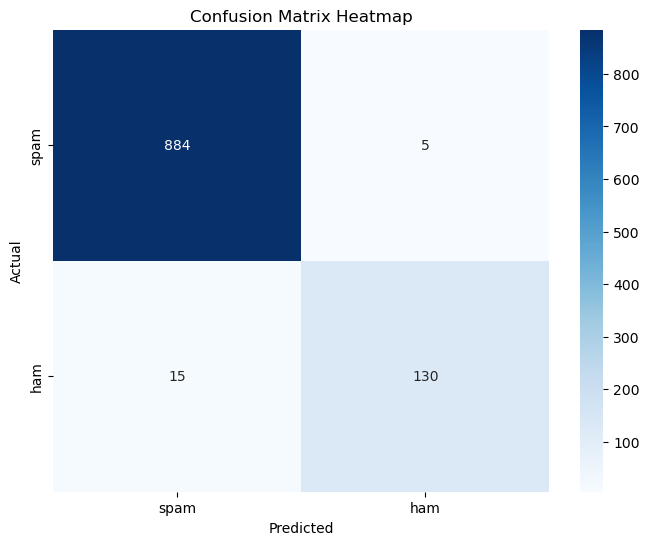

In [43]:
# Create a heatmap of the confusion matrix

plt.figure(figsize = (8, 6))

sns.heatmap(conf_matrix, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = ['spam', 'ham'], 
            yticklabels = ['spam', 'ham'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()